In [ ]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 120 (delta 54), reused 99 (delta 38), pack-reused 0
Receiving objects: 100% (120/120), 98.64 KiB | 8.22 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [1]:
import sys
sys.path.append('/Users/aleksandr/Desktop/newGAN/glo-flow')
sys.path

['/Users/aleksandr/Desktop/newGAN/glo-flow/notebooks',
 '/Users/aleksandr/miniconda/lib/python38.zip',
 '/Users/aleksandr/miniconda/lib/python3.8',
 '/Users/aleksandr/miniconda/lib/python3.8/lib-dynload',
 '',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages',
 '/Users/aleksandr/Desktop/hacks/liders/Real-ESRGAN',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages/IPython/extensions',
 '/Users/aleksandr/.ipython',
 '/Users/aleksandr/Desktop/newGAN/glo-flow']

In [ ]:
!pip install -q comet_ml

     |████████████████████████████████| 299 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 530 kB 60.4 MB/s 


In [2]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

BW_METHOD = 0.1
N_COMPONENTS = 128

In [ ]:
mnist = fetch_openml(name='mnist_784', version='active')

In [ ]:
pca = PCA(n_components=N_COMPONENTS)
data = pca.fit_transform(mnist.data)

In [ ]:
data = data.T
data.shape

(32, 70000)

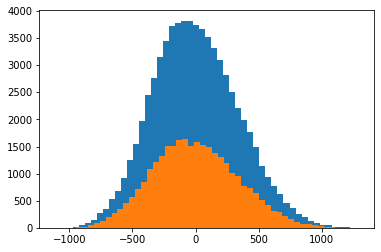

In [ ]:
i = 6
plt.hist(data[i], bins=50)
kernel = gaussian_kde(data, bw_method=BW_METHOD)
sample = kernel.resample(30_000)
_ = plt.hist(sample[i], bins=50)

### Training the model

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
from modules.glo import GLOGenerator, GLOModel, SampleGenerator
from modules.train import GLOTrainer, visualize_image_grid
from modules.dataset import IdxDataset
from modules.validate import Validator
from modules.loss import LapLoss

In [4]:
mnist_train = MNIST(root='datasets', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = MNIST(root='datasets', train=False, transform=transforms.ToTensor(), download=True)

In [5]:
mnist_train = IdxDataset(mnist_train)
mnist_test = IdxDataset(mnist_test)

In [6]:
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=False)
val_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [8]:
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader).to(device)
sample_generator = SampleGenerator(train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator).to(device)

CPU times: user 17.4 s, sys: 1.93 s, total: 19.4 s
Wall time: 5.48 s


In [ ]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='glo-mnist',
                        workspace='alexandernevarko')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/glo-mnist/e6cdd673a6a445f4b96988585c9e0e6e



In [ ]:
trainer = GLOTrainer(model, use_gpu=True, logger=experiment)

In [ ]:
zlr = 1e2
loss_func = LapLoss(max_levels=2, channels=1, device=device)
optimizer = torch.optim.SGD([
    {'params': model.generator.parameters(), 'lr': 1e-3},
    {'params': model.z, 'lr': zlr}
])

In [ ]:
torch.sum(model.z[0]**2)

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
model.z

Parameter containing:
tensor([[ 0.2413,  0.5008,  0.0106,  ..., -0.0573, -0.0700,  0.1619],
        [ 0.1907,  0.2961,  0.2604,  ..., -0.0041,  0.1968, -0.0699],
        [ 0.0115,  0.2553, -0.3173,  ...,  0.1083,  0.0628,  0.3200],
        ...,
        [ 0.3101, -0.3301, -0.1279,  ..., -0.0187, -0.0857,  0.2775],
        [-0.5213, -0.1204, -0.0061,  ...,  0.1303, -0.1214,  0.0952],
        [-0.0680,  0.1857,  0.3340,  ..., -0.1016, -0.1371,  0.1812]],
       device='cuda:0', requires_grad=True)

In [ ]:
model.z

Parameter containing:
tensor([[-3.3878e-01,  3.1108e-01, -1.7770e-01,  ...,  1.3327e-04,
          1.0573e-02,  3.0073e-02],
        [-2.9746e-01,  4.5952e-01,  3.1052e-02,  ...,  1.2081e-02,
          9.1287e-03,  7.1439e-03],
        [ 9.5864e-02,  2.7947e-01, -4.0255e-01,  ...,  1.4511e-03,
         -3.4034e-02,  3.4174e-02],
        ...,
        [ 1.8333e-01,  1.5791e-01,  2.9805e-02,  ..., -1.8981e-02,
         -1.6791e-02,  2.7939e-02],
        [-1.3625e-01, -5.8471e-02,  1.1890e-01,  ...,  2.8830e-02,
         -3.3027e-02, -1.5449e-03],
        [ 1.9912e-01, -3.7841e-01, -1.3152e-01,  ..., -7.2910e-03,
         -1.4502e-02,  8.2203e-03]], requires_grad=True)

In [ ]:
n_epochs = 25
trainer.train(n_epochs=n_epochs, train_loader=train_loader, 
              loss_func=loss_func, optimizer=optimizer, 
              exp_name=f'LapL1_z_{N_COMPONENTS}_zlr_1e2_{n_epochs}_epochs', model_path='')

Average epoch 0 loss: 0.19293082938989004


Average epoch 1 loss: 0.17212671472231547


Average epoch 2 loss: 0.1636009076913198


Average epoch 3 loss: 0.15098719016710918


Average epoch 4 loss: 0.13004513396422068


Average epoch 5 loss: 0.11314168674548467


Average epoch 6 loss: 0.11507284744580587


Average epoch 7 loss: 0.1057509601076444


Average epoch 8 loss: 0.09521731353998185


Average epoch 9 loss: 0.09282050196727117


Average epoch 10 loss: 0.08877835182348887


Average epoch 11 loss: 0.08470930225849152


Average epoch 12 loss: 0.08236180653174718


Average epoch 13 loss: 0.07999162180026373


Average epoch 14 loss: 0.07791733359495799


Average epoch 15 loss: 0.07621198108593623


Average epoch 16 loss: 0.07476287625829378


Average epoch 17 loss: 0.07334578002492587


Average epoch 18 loss: 0.07222030189037323


Average epoch 19 loss: 0.07110988792777062


Average epoch 20 loss: 0.07013097624182701


Average epoch 21 loss: 0.06922257430752118


Average epoch 22 loss: 0.06844976392785708


Average epoch 23 loss: 0.06770526091257731


Average epoch 24 loss: 0.06706139348546664


In [ ]:
# model.load_state_dict(torch.load('/content/m/z_32_zlr_1e2_50_epochs_model.pth'))

<All keys matched successfully>

In [ ]:
z = nn.Parameter(torch.randn(size=(len(val_loader.dataset), N_COMPONENTS), device=device, requires_grad=True))
optimizer = torch.optim.SGD([z], lr=5e1)
loss_func = LapLoss(max_levels=2, channels=1, device=device)

validator = Validator(model, val_loader, loss_func, optimizer)

In [ ]:
z_new, loss = validator.validate(z=z, min_loss=0.06, max_iter=60)

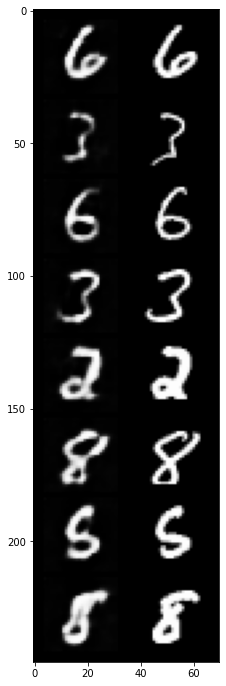

In [ ]:
idx = torch.randint(low=0, high=len(z), size=(8, ))
img = []
for i in idx:
    img.append(train_loader.dataset[i][1])
img = torch.cat(img).view(8, 1, 28, 28)
res = validator.visualize_val_results(z=model.z[idx], img=img)
plt.figure(figsize=(18, 12))
plt.imshow(res)

In [ ]:
img.shape

torch.Size([8, 1, 28, 28])

In [ ]:
!rm -rf glo-flow

Now let's look at the model Z distribution!

In [ ]:
z_numpy = model.z.detach().cpu().numpy()

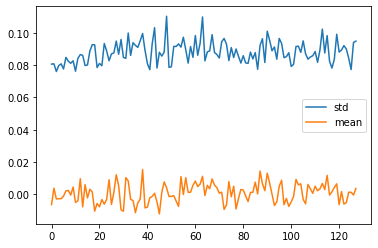

In [ ]:
plt.plot(z_numpy.std(axis=0), label='std')
plt.plot(z_numpy.mean(axis=0), label='mean')
plt.legend()

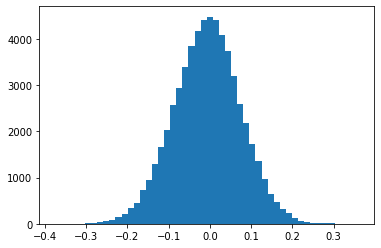

In [ ]:
_ = plt.hist(z_numpy[:, 0], bins=50)

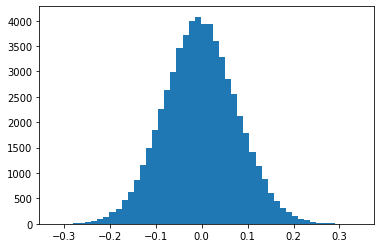

In [ ]:
_ = plt.hist(z_numpy[:, -10], bins=50)

In [ ]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([0, 3, 5])
torch.amax(torch.vstack([a, b]), dim=0)

tensor([1, 3, 5])

In [ ]:
a.long()

tensor([1, 2, 3])

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/glo-mnist/e6cdd673a6a445f4b96988585c9e0e6e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [25] : (0.06706139348546664, 0.19293082938989004)
COMET INFO:     Train loss [46875]            : (0.053143858909606934, 0.24696052074432373)
COMET INFO:     loss [5266]                   : (0.053791023790836334, 0.26565197110176086)
COMET INFO:   Others:
COMET INFO:     Name : LapL1_z_128_zlr_1e2_25_epochs
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 25
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
C